# Red Tensorflow desde Cero

## Generar datos

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

# Creamos nuestros datos artificiales, donde buscaremos clasificar 
# dos anillos concéntricos de datos. 
X, Y = make_circles(n_samples=500, factor=0.6, noise=0.1)

# Resolución del mapa de predicción.
res = 100 

# Coordendadas del mapa de predicción.
_x0 = np.linspace(-1.5, 1.5, res)
_x1 = np.linspace(-1.5, 1.5, res)

# Input con cada combo de coordenadas del mapa de predicción.
_pX = np.array(np.meshgrid(_x0, _x1)).T.reshape(-1, 2)

# Objeto vacio a 0.5 del mapa de predicción.
_pY = np.zeros((res, res)) + 0.5

# Visualización del mapa de predicción.
plt.figure(figsize=(8, 8))
plt.pcolormesh(_x0, _x1, _pY, cmap="coolwarm", vmin=0, vmax=1)

# Visualización de la nube de datos.
plt.scatter(X[Y == 0,0], X[Y == 0,1], c="skyblue")
plt.scatter(X[Y == 1,0], X[Y == 1,1], c="salmon")

plt.tick_params(labelbottom=False, labelleft=False)

## Modelo con Tensorflow

In [3]:
from matplotlib import animation
from IPython.core.display import display, HTML

import tensorflow as tf

*El punto de partida del código en tensorflow es **definir** explícitamente qué **operaciones** forman el grafo computacional. Es decir, cómo los **datos (tensores)** van fluyendo y transformándose de principio a fin.*

In [4]:
#Creo puntos de entrada de la red
x = tf.placeholder('float', shape = [None,X.shape[1]])  # Matriz X de datos
y = tf.placeholder('float', shape = [None])    # Vector Y de respuestas

*Los **placeholders** se usan para definir los **puntos de entrada del grafo,** donde se van a insertar los datos a la red y donde se obtienen los datos de salida. Son marcadores de posición para tensores que pueden usarse para alimentarse con un valor el cuál será evaluado, pero no pueden ser evaluados directamente.*

* *Firma: tf.placeholder(dtype, shape=None, name=None)*

In [5]:
topologia = [2, 16, 8, 1]   # Número de neuronas por capa 
lr = 0.05                   # Tasa de aprendizaje (larning rate) del optimizador.

### Defino grafo de operaciones que forman la red:

In [6]:
#Capa 1
w1 = tf.Variable(tf.random_normal([topologia[0],topologia[1]]), name = "Pesos_1")
b1 = tf.Variable(tf.random_normal([topologia[1]]), name= "Bias_1")
op1 = tf.nn.relu(tf.add(tf.matmul(x,w1),b1))

Instructions for updating:
Colocations handled automatically by placer.


*Las **variables** se usan para definir los **parametros que serán optimizados** dentro de la red.  En este caso, las variables son inicializadas con valores aleatorios y con las dimensiones indicadas.*

* *Firma: tf.Variable(valor-inicial, name=nombre-opcional)*


*En cada capa se realiza una suma ponderada, equivalente a una **multiplicacion matricial** luego se le **suma** el parametro bias y todo eso se pasa por una **funcion de activacion**.*

* *Firma multiplicacion matricial: tf.matmul(matriz-a, matriz-b, transpose_a=False, transpose_b=False, adjoint_a=False, adjoint_b=False)*

*Ambas matrices deben ser del mismo tipo de dato. Adjoint significa traspuesta y conjugada.*

* *Firma suma: tf.add(tensor-x, tensor-y, name=None)*

*Ambos tensores deben ser del mismo tipo de dato.*

* *Firma func. act: tf.nn.relu(tensor-de-features, name=None)*

In [7]:
#Capa 2
w2 = tf.Variable(tf.random_normal([topologia[1],topologia[2]]), name = "Pesos_2")
b2 = tf.Variable(tf.random_normal([topologia[2]]), name= "Bias_2")
op2 = tf.nn.relu(tf.add(tf.matmul(op1,w2),b2))

#Capa 3
w3 = tf.Variable(tf.random_normal([topologia[2],topologia[3]]), name = "Pesos_3")
b3 = tf.Variable(tf.random_normal([topologia[3]]), name= "Bias_3")
yp = tf.nn.sigmoid(tf.add(tf.matmul(op2,w3),b3)) [:,0]  #Vector final de predicciones

In [8]:
#Calculo error de la prediccion obtenida
error = tf.losses.mean_squared_error(yp, y)

Instructions for updating:
Use tf.cast instead.


*Una vez obtenida la prediccion tengo que compararla con los resultados reales mediante una funcion de costo.*

*En este caso la **funcion de costo** es el ECM.*

### Procedo a entrenar la red

In [9]:
#Elijo el decenso del gradiente como metodo para minimizar el error obtenido en la prediccion.
optimizador = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(error)

*Un **optimizador**, es un método para minimizar el error. En este caso, es el Descenso del gradiente*

In [10]:
ciclos_train = 1000  #Número de ciclos para entrenamiento.

iPY = [] # Aquí guardaremos la evolución de las predicción, para la animación posterior.

with tf.Session() as sess: #Se inicia una sesion para alimentar los tensores y ejecutar el grafo computacional.
  
  # Inicializamos todas las variables, las matrices W y b.
  sess.run(tf.global_variables_initializer())
    
  # Iteramos ciclos de entrenamiento.
  for ciclo in range(ciclos_train):
  
    # Evaluamos al optimizador, a la función de coste y al tensor de salida pY. 
    # La evaluación del optimizer producirá el entrenamiento de la red.
    _, _error, _yp = sess.run([optimizador, error, yp], feed_dict={ x : X, y : Y })
    
    # Cada 25 iteraciones, imprimimos métricas.
    if ciclo % 25 == 0: 
      
      # Cálculo del accuracy.
      acc = np.mean(np.round(_yp) == Y)  #¿A cuántos individuos le atinó la prediccion?
      
      # Impresión de métricas.
      print('Ciclo de entrenamiento', ciclo, '/', ciclos_train, '- ECM = ', _error, '- Precisión =', acc)
      
      # Obtenemos predicciones para cada punto de nuestro mapa de predicción _pX.
      _pY = sess.run(yp, feed_dict={ x : _pX }).reshape((res, res))

      # Y lo guardamos para visualizar la animación.
      iPY.append(_pY)
  
  #print(sess.run(yp, feed_dict={x:X}))

Ciclo de entrenamiento 0 / 1000 - ECM =  0.42329907 - Precisión = 0.478
Ciclo de entrenamiento 25 / 1000 - ECM =  0.37871137 - Precisión = 0.512
Ciclo de entrenamiento 50 / 1000 - ECM =  0.302649 - Precisión = 0.398
Ciclo de entrenamiento 75 / 1000 - ECM =  0.24987026 - Precisión = 0.534
Ciclo de entrenamiento 100 / 1000 - ECM =  0.22160895 - Precisión = 0.636
Ciclo de entrenamiento 125 / 1000 - ECM =  0.20311153 - Precisión = 0.69
Ciclo de entrenamiento 150 / 1000 - ECM =  0.1920623 - Precisión = 0.714
Ciclo de entrenamiento 175 / 1000 - ECM =  0.18356921 - Precisión = 0.734
Ciclo de entrenamiento 200 / 1000 - ECM =  0.1768261 - Precisión = 0.744
Ciclo de entrenamiento 225 / 1000 - ECM =  0.1706859 - Precisión = 0.756
Ciclo de entrenamiento 250 / 1000 - ECM =  0.1645794 - Precisión = 0.772
Ciclo de entrenamiento 275 / 1000 - ECM =  0.158569 - Precisión = 0.8
Ciclo de entrenamiento 300 / 1000 - ECM =  0.15235569 - Precisión = 0.814
Ciclo de entrenamiento 325 / 1000 - ECM =  0.14615387 

## Animación

--- Generando animación ---
hola


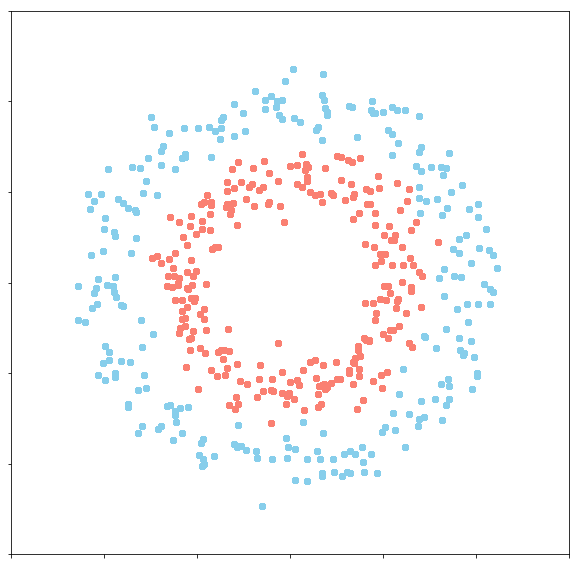

In [14]:
ims = []

fig = plt.figure(figsize=(10, 10))

print("--- Generando animación ---")

for fr in range(len(iPY)):
  
  im = plt.pcolormesh(_x0, _x1, iPY[fr], cmap="coolwarm", animated=True)

  # Visualización de la nube de datos.
  plt.scatter(X[Y == 0,0], X[Y == 0,1], c="skyblue")
  plt.scatter(X[Y == 1,0], X[Y == 1,1], c="salmon")

  # plt.title("Resultado Clasificación")
  plt.tick_params(labelbottom=False, labelleft=False)

  ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
HTML(ani.to_html5_video())